In [1]:
# Imports
import os, sys

# pandas
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

#keras
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Input, concatenate, Flatten, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
sys.path.append('../../lotufo')
from my_keras_utilities import (get_available_gpus, load_model_and_history, save_model_and_history, TrainingPlotter)

Using TensorFlow backend.


In [2]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        
def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  shuffle=True,
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval),
                      shuffle=shuffle,
                      callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

## Load data

In [3]:
titanic_train = pd.read_csv('../Data/train.csv')
titanic_test = pd.read_csv('../Data/test.csv')

# print(titanic_train.info())
# print('-'*100)
# print(titanic_test.info())
# # titanic_train.head(-1)

## Remove not interesting data

##### remove data that should not be relevant to the prediction

In [4]:
# titanic_train = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
titanic_train = titanic_train.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
# titanic_test = titanic_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_test = titanic_test.drop(['Ticket', 'Cabin'], axis=1)
print(titanic_train.info())
print('-'*100)
print(titanic_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int6

## Filling empty data

##### fill missing Fare and the missing Ages based on the person title ( miss, mrs, mr, etc.)

In [5]:
# miss, mrs, mr, master
age = titanic_train.Age.as_matrix().copy()

aux = (titanic_train.Name.str.find('Miss.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 20 #'young'
aux = (titanic_train.Name.str.find('Mr.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_train.Name.str.find('Mrs.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_train.Name.str.find('Master.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 5 #'kids'
aux = (titanic_train.Name.str.find('Dr.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
aux = (titanic_train.Name.str.find('Ms.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
titanic_train.Age = age

age = titanic_test.Age.as_matrix().copy()
aux = (titanic_test.Name.str.find('Miss.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 20 #'young'
aux = (titanic_test.Name.str.find('Mr.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_test.Name.str.find('Mrs.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_test.Name.str.find('Master.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 5 #'kids'
aux = (titanic_test.Name.str.find('Dr.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
aux = (titanic_test.Name.str.find('Ms.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
titanic_test.Age = age



titanic_test.Fare[np.asarray(np.where(np.isnan(titanic_test.Fare.as_matrix()))).reshape(1)] = 10

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Remove rows with missing data

###### remove (just a few) rows that are missing Embarked information

In [6]:
# titanic_train = titanic_train[titanic_train.Age.notnull()]
# titanic_test = titanic_test[titanic_test.Age.notnull()]

titanic_train = titanic_train[titanic_train.Embarked.notnull()]
# titanic_test = titanic_test[titanic_test.Embarked.notnull()]

# titanic_train = titanic_train[titanic_train.Fare.notnull()]
# titanic_test = titanic_test[titanic_test.Fare.notnull()]

print(titanic_train.info())
print('-'*100)
print(titanic_test.info())
titanic_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int6

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,S


## Catogorize and normalize data

###### Caterorize ages in 5 ranges

In [7]:
Age_norm_train_cat = titanic_train.Age.as_matrix()
Age_norm_train_cat[Age_norm_train_cat <= 10] = 0 #'kids'
Age_norm_train_cat[(Age_norm_train_cat > 10) * (Age_norm_train_cat <= 20)] = 1 #'teen'
Age_norm_train_cat[(Age_norm_train_cat > 20) * (Age_norm_train_cat <= 30)] = 2 #'young'
Age_norm_train_cat[(Age_norm_train_cat > 30) * (Age_norm_train_cat <= 55)] = 3 #'adult'
Age_norm_train_cat[(Age_norm_train_cat > 55)] = 4 #'old'
# Age_norm_train_cat


Age_norm_test_cat = titanic_test.Age.as_matrix()
Age_norm_test_cat[Age_norm_test_cat <= 10] = 0 #'kids'
Age_norm_test_cat[(Age_norm_test_cat > 10) * (Age_norm_test_cat <= 18)] = 1 #'teen'
Age_norm_test_cat[(Age_norm_test_cat > 18) * (Age_norm_test_cat <= 30)] = 2 #'young'
Age_norm_test_cat[(Age_norm_test_cat > 30) * (Age_norm_test_cat <= 55)] = 3 #'adult'
Age_norm_test_cat[(Age_norm_test_cat > 55)] = 4 #'old'

## Normalize categorical data

In [8]:
#train
Pclass_classes_train, Pclass_norm_train = np.unique(titanic_train.Pclass.as_matrix(), return_inverse=True)
Sex_classes_train, Sex_norm_train = np.unique(titanic_train.Sex.as_matrix(), return_inverse=True)
Age_classes_train, Age_norm_train_cat = np.unique(Age_norm_train_cat, return_inverse=True)
# SibSp_classes_train, SibSp_norm_train = np.unique(titanic_train.SibSp.as_matrix(), return_inverse=True)
# Parch_classes_train, Parch_norm_train = np.unique(titanic_train.Parch.as_matrix(), return_inverse=True)
Embarked_classes_train, Embarked_norm_train = np.unique(titanic_train.Embarked.as_matrix(), return_inverse=True)

#test
Pclass_classes_test, Pclass_norm_test = np.unique(titanic_test.Pclass.as_matrix(), return_inverse=True)
Sex_classes_test, Sex_norm_test = np.unique(titanic_test.Sex.as_matrix(), return_inverse=True)
Age_classes_test, Age_norm_test_cat = np.unique(Age_norm_test_cat, return_inverse=True)
# SibSp_classes_test, SibSp_norm_test = np.unique(titanic_test.SibSp.as_matrix(), return_inverse=True)
# Parch_classes_test, Parch_norm_test = np.unique(titanic_test.Parch.as_matrix(), return_inverse=True)
Embarked_classes_test, Embarked_norm_test = np.unique(titanic_test.Embarked.as_matrix(), return_inverse=True)



## Normalize non categorical data

In [9]:
#train
# Age_norm_train = titanic_train.Age.as_matrix()
# Age_max = np.max(Age_norm_train)
# Age_norm_train = Age_norm_train / Age_max

SibSp_norm_train = titanic_train.SibSp.as_matrix()
SibSp_max = np.max(SibSp_norm_train)
SibSp_norm_train = SibSp_norm_train / SibSp_max

Parch_norm_train = titanic_train.Parch.as_matrix()
Parch_max = np.max(Parch_norm_train)
Parch_norm_train = Parch_norm_train / Parch_max

Fare_norm_train = titanic_train.Fare.as_matrix()
Fare_max = np.max(Fare_norm_train)
Fare_norm_train = Fare_norm_train / Fare_max

#test (use the same normalization)
# Age_norm_test = titanic_test.Age.as_matrix()
# Age_norm_test = Age_norm_test / Age_max

SibSp_norm_test = titanic_test.SibSp.as_matrix()
SibSp_norm_test = SibSp_norm_test / SibSp_max

Parch_norm_test = titanic_test.Parch.as_matrix()
Parch_norm_test = Parch_norm_test / Parch_max

Fare_norm_test = titanic_test.Fare.as_matrix()
Fare_norm_test = Fare_norm_test / Fare_max

# Build Keras Model

In [10]:
#Survived Pclass Sex Age SibSp Parch Fare Embarked
def build_keras_model():
    Pclass_in = Input(shape=(1,), dtype='int64', name='Pclass_in')
    x = Embedding(Pclass_classes_train.size, 3, input_length=1, name='Pclass_embedding')(Pclass_in)
    Pclass_emb = Flatten(name='Pclass_flatten')(x)
    
    Sex_in = Input(shape=(1,), name='Sex_in')
    Sex_out = Dense(1, input_dim=1)(Sex_in)
    
#     Age_in = Input(shape=(1,), name='Age_in')
#     Age_out = Dense(1, input_dim=1)(Age_in)
    Age_in = Input(shape=(1,), dtype='int64', name='Age_in')
    x = Embedding(Age_classes_train.size, 4, input_length=1, name='Age_embedding')(Age_in)
    Age_emb = Flatten(name='Age_flatten')(x)
    
    SibSp_in = Input(shape=(1,), name='SibSp_in')
    SibSp_out = Dense(1, input_dim=1)(SibSp_in)
    
    Parch_in = Input(shape=(1,), name='Parch_in')
    Parch_out = Dense(1, input_dim=1)(Parch_in)
    
    Fare_in = Input(shape=(1,), name='Fare_in')
    Fare_out = Dense(1, input_dim=1)(Fare_in)
    
    Embarked_in = Input(shape=(1,), dtype='int64', name='Embarked')
    x = Embedding(3, 2, input_length=1, name='Embarked_embedding')(Embarked_in)
    Embarked_emb = Flatten(name='Embarked_flatten')(x)
    
    
#     xin = concatenate([Pclass_emb, Sex_out, Age_out, SibSp_out, Parch_out, Fare_out, Embarked_emb])
    xin = concatenate([Pclass_emb, Sex_out, Age_emb, SibSp_out, Parch_out, Fare_out, Embarked_emb])
    x = Dense(100, kernel_initializer='random_uniform', activation='relu')(xin)
    x = Dropout(0.8)(x)
    x = Dense(50, kernel_initializer='random_uniform', activation='relu')(xin)
    x = Dropout(0.8)(x)
    x = Dense(10, kernel_initializer='random_uniform', activation='relu')(x)
    x_out = Dense(1, activation='sigmoid')(x)
    
    return Model([Pclass_in, Sex_in, Age_in, SibSp_in, Parch_in, Fare_in, Embarked_in], x_out)

model_ti = build_keras_model()
model_ti.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Pclass_in (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
Age_in (InputLayer)              (None, 1)             0                                            
____________________________________________________________________________________________________
Embarked (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
Pclass_embedding (Embedding)     (None, 1, 3)          9           Pclass_in[0][0]                  
___________________________________________________________________________________________

# Show the model

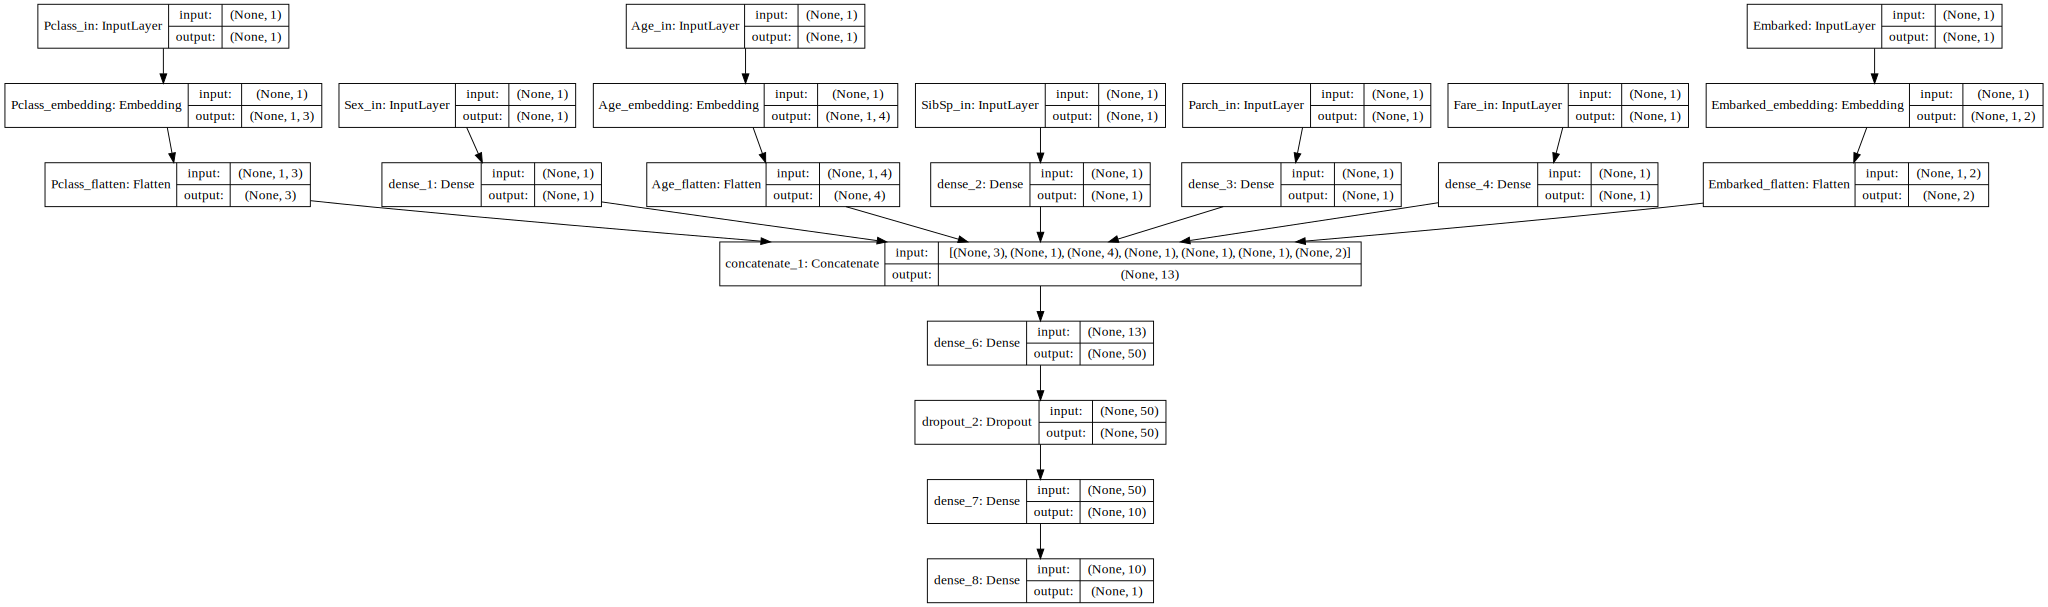

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_ti, show_shapes=True).create(prog='dot', format='svg'))

# Create validation data from the train data

In [12]:
num_records = len(titanic_train['Survived'].as_matrix())
train_ratio = 0.9
train_size = int(train_ratio * num_records)


# Age as non categoriacal
# X_train_p = [Pclass_norm_train[:train_size], Sex_norm_train[:train_size], Age_norm_train[:train_size],
#              SibSp_norm_train[:train_size], Parch_norm_train[:train_size],
#              Fare_norm_train[:train_size], Embarked_norm_train[:train_size]]
# y_train = titanic_train['Survived'].as_matrix()[:train_size]

# X_val_p = [Pclass_norm_train[train_size:], Sex_norm_train[train_size:], Age_norm_train[train_size:],
#              SibSp_norm_train[train_size:], Parch_norm_train[train_size:],
#              Fare_norm_train[train_size:], Embarked_norm_train[train_size:]]
# y_val = titanic_train['Survived'].as_matrix()[train_size:]

# Age as categoriacal
X_train_p = [Pclass_norm_train[:train_size], Sex_norm_train[:train_size], Age_norm_train_cat[:train_size],
             SibSp_norm_train[:train_size], Parch_norm_train[:train_size],
             Fare_norm_train[:train_size], Embarked_norm_train[:train_size]]
y_train = titanic_train['Survived'].as_matrix()[:train_size]

X_val_p = [Pclass_norm_train[train_size:], Sex_norm_train[train_size:], Age_norm_train_cat[train_size:],
             SibSp_norm_train[train_size:], Parch_norm_train[train_size:],
             Fare_norm_train[train_size:], Embarked_norm_train[train_size:]]
y_val = titanic_train['Survived'].as_matrix()[train_size:]

# Train the model

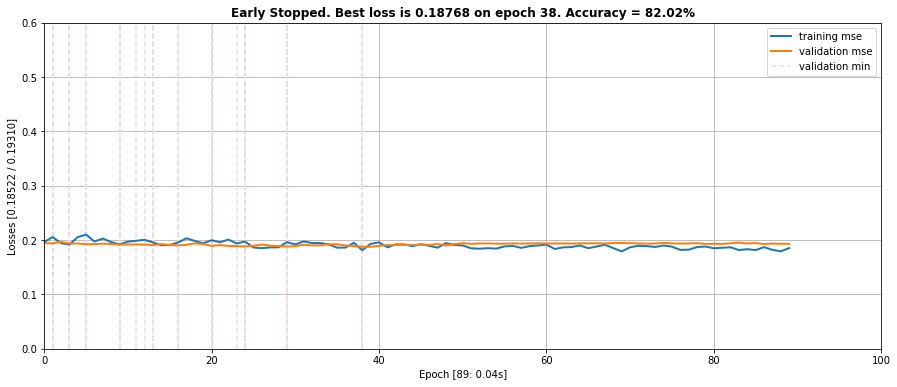

In [50]:
model_name = '../model_ti'
fit_params = {
    'model_name': model_name,
    'loss': 'mean_absolute_error',
#     'opt':        Adam(), 
    'batch_size': 50, 
    'nepochs':    100,
    'patience':   50, 
    'ploss':      0.6,
    'shuffle':    False,
    'reset':      True,
}

train_network(model_ti, X_train_p, y_train, X_val_p, y_val, **fit_params);

# Evaluate the model

In [14]:
loss = model_ti.evaluate(X_val_p, y_val, verbose=0)
print('Final loss:',loss)

W = model_ti.get_weights()
print('Bias:\n', W[1])
print('W:\n', W[0])

Y_hat = model_ti.predict(X_val_p)
accuracy = sum((Y_hat.reshape(len(y_val))>0.5) == y_val)/(float(len(y_val)))
accuracy

Final loss: [0.19524681375602657, 0.82022472378912936]
Bias:
 [[-0.15162815 -0.06514571 -0.08372805 -0.10722222]
 [-0.16952088 -0.02186148 -0.0363256  -0.0175445 ]
 [ 0.03661642  0.09187569  0.05865068  0.07984108]
 [ 0.1379534   0.29245213  0.28402677  0.30004853]
 [ 0.00151483  0.02829626  0.03592106  0.02772075]]
W:
 [[-0.07879684  0.43952993 -0.44390047]
 [-0.22555417  0.35080764 -0.43752623]
 [ 0.16760238 -0.18446741  0.21402088]]


0.8202247191011236

# Predict

In [46]:
X_test = [Pclass_norm_test, Sex_norm_test, Age_norm_test_cat, SibSp_norm_test, Parch_norm_test, Fare_norm_test, Embarked_norm_test]
Y_test = model_ti.predict(X_test) > 0.5
# Y_test.reshape((len(Y_test),)) 
Y_test = np.squeeze(Y_test) * 1

In [49]:
my_prediction = pd.DataFrame({'PassengerId':titanic_test['PassengerId'].values,'Survived':Y_test})
my_prediction.to_csv("my_prediction.csv")

In [48]:
my_prediction

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
